In [1]:
# Import required packages
import torch
import torch.nn as nn
import numpy as np
import normflow as nf
import mdtraj
import sys
sys.path.append("../")
import boltzgen.mixed as mixed

from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# Need a more generic flow as we don't have a target dist
# and won't be using the KL loss
class SNFlow(nn.Module):
    def __init__(self, q0, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.q0 = q0

    def forward(self, num_samples):
        # Draw some samples from q0 and pass them forward through the flow
        dummy_var = torch.zeros((num_samples,))
        x, _ = self.q0(dummy_var, num_samples=1)
        x = x.view((x.shape[0], x.shape[2]))
        totlogdet = torch.zeros((x.shape[0],))
        for flow in self.flows:
            x, logdet = flow(x)
            totlogdet += logdet

        return x, totlogdet

    def inverse(self, x):
        # Pass the given x backward through the flow
        tot_invlogdet = torch.zeros((x.shape[0],))

        for i in range(len(self.flows)-1, -1, -1):
            x, invlogdet = self.flows[i].inverse(x)
            tot_invlogdet += invlogdet

        return x, tot_invlogdet

    def dih_quad_loss(self, batch_size):
        # Quadratic loss on dihedral angle dimensions only applied
        # outside the range +/- pi.
        # As described in the boltzmann generators supplementary materials
        x, _ = self.forward(batch_size)
        # dih_indeces are the dimensions corresponding to the dihedral angles
        dih_indeces = [20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59]
        dih_x = x[:, dih_indeces]
        vio_dih_x = torch.where(torch.abs(dih_x)>3.1416, dih_x,
            torch.tensor(0).double())
        loss = torch.mean(torch.sum(vio_dih_x ** 2, dim=-1))
        return loss

In [3]:
# If not done already, generate the 10^5 training samples

import openmmtools
from openmmtools.constants import kB
from simtk import openmm as mm
from simtk import unit
from simtk.openmm import app
from openmmtools.testsystems import AlanineDipeptideVacuum
import mdtraj
from sys import stdout
from simtk.openmm.app import *

temperature = 1000
kT = kB * temperature
testsystem = AlanineDipeptideVacuum()
vacuum_sim = app.Simulation(testsystem.topology,
                            testsystem.system,
                            mm.LangevinIntegrator(temperature * unit.kelvin , 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                            platform=mm.Platform.getPlatformByName('CPU')
                            )
vacuum_sim.context.setPositions(testsystem.positions)
vacuum_sim.minimizeEnergy()
vacuum_sim.reporters.append(mdtraj.reporters.HDF5Reporter('aldp_training_data.h5', 10))
vacuum_sim.reporters.append(StateDataReporter(stdout, 100000, step=True,
        potentialEnergy=True, temperature=True))
vacuum_sim.step(1000000)

KeyboardInterrupt: 

In [4]:
# Load the training data 
aldp_traj = mdtraj.load('/scratch2/vs488/flow/alanine_dipeptide/trajectory/aldp100.h5')
z = [
    (1, [4, 5, 6]),
    (0, [1, 4, 5]),
    (2, [1, 0, 4]),
    (3, [1, 0, 2]),
    (7, [6, 4, 5]),
    (9, [8, 6, 5]),
    (10, [8, 6, 9]),
    (11, [10, 8, 5]),
    (12, [10, 8, 11]),
    (13, [10, 11, 12]),
    (17, [16, 14, 15]),
    (19, [18, 16, 17]),
    (20, [18, 19, 16]),
    (21, [18, 19, 20])
]
backbone_indices = [4, 5, 6, 8, 14, 15, 16, 18]
aldp_traj.center_coordinates()
ind = aldp_traj.top.select("backbone")
aldp_traj.superpose(aldp_traj, 0, atom_indices=ind, ref_atom_indices=ind)

training_data = aldp_traj.xyz
n_atoms = training_data.shape[1]
n_dim = n_atoms * 3
training_data_npy = training_data.reshape(-1, n_dim)
training_data = torch.from_numpy(training_data_npy.astype("float32"))
training_data.double()

# We can pre-apply the mixed transform to all the training data
# and then fit the flow to the transformed data meaning
# that we don't need to put the transform at the end of the
# flow

mixed_transform = mixed.MixedTransform(66, backbone_indices, z, training_data)
x, _ = mixed_transform.forward(training_data)
print("Training data shape", x.shape)

Training data shape torch.Size([100, 60])


In [7]:
# ------------ Set up model -----------

# Define flows
K = 6
#torch.manual_seed(0)

# If we use the the 'velocity' dimensions as mentioned
# in the stochastic normalizing flows paper we need
# to double the dimensionality of the flow.
# Since we are fitting the flow to the transformed
# training data there are 60 dimensions since the
# original data has 66 dims and 6 dims are discarded
# in the transform
flow_dim = 120
b = torch.zeros((flow_dim,))
b[int(flow_dim/2):flow_dim] = 1
flows = []
for i in range(K):
    s = nf.nets.MLP([flow_dim, 128, 128, 128, flow_dim])
    t = nf.nets.MLP([flow_dim, 128, 128, 128, flow_dim])
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, s, t)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, s, t)]

q0 = nf.distributions.ConstDiagGaussian(np.zeros(flow_dim, dtype=np.float32), np.ones(flow_dim, dtype=np.float32))

# Construct flow model
nfm = SNFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
print("Device: ", device)
nfm = nfm.to(device)
nfm = nfm.double()

Device:  cpu


In [11]:
num_epochs = 100
mini_batch_size = 256

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-6, weight_decay=1e-3)
for epoch_idx in range(num_epochs):
    shuffled_ids = torch.randperm(x.shape[0])
    epoch_losses = []
    for batch_idx in range(0, x.shape[0], mini_batch_size):
        mini_batch_ids = shuffled_ids[batch_idx:batch_idx+mini_batch_size]
        mini_batch = x[mini_batch_ids]

        optimizer.zero_grad()

        mini_batch = mini_batch.double()
        # augment the training sample with 60 'velocities'
        vels = torch.randn_like(mini_batch)
        y = torch.cat([mini_batch, vels], 1)
        y0, invlogdet = nfm.inverse(y)
        y02 = torch.matmul(y0.view((y0.shape[0], 1, y0.shape[1])),
            y0.view((y0.shape[0], y0.shape[1], 1))).view((y0.shape[0],))
        Jml = y02.mean() - invlogdet.mean()
        dih_loss = nfm.dih_quad_loss(mini_batch_size)
        dual_loss = Jml + dih_loss

        dual_loss.backward()
        optimizer.step()
        epoch_losses.append([Jml.cpu().data.numpy(), dih_loss.cpu().data.numpy()])

    epoch_losses = np.array(epoch_losses)
    print("Jml", np.mean(epoch_losses[:, 0]), "dih", np.mean(epoch_losses[:, 1]))

Jml 105.02828945061849 dih 0.8280649578444996
Jml 106.44871769721134 dih 0.4455913382218335
Jml 105.75209370368437 dih 0.5283177605948988
Jml 106.31100570952077 dih 0.5433764000315927
Jml 106.77320593369605 dih 0.4048368633647577
Jml 106.50384270971021 dih 0.48912908789240434
Jml 104.52944601337252 dih 0.5841807847308017
Jml 107.94856142757399 dih 0.9445198202732883
Jml 106.58698366250265 dih 0.7896572935652706
Jml 105.308081335629 dih 0.4901136284276598
Jml 104.56466400180426 dih 0.4160740202497648
Jml 105.228904515097 dih 0.5053593304781867
Jml 106.1707910225034 dih 0.697774399351789
Jml 107.79164613603623 dih 0.5606818090627954
Jml 105.24806918602903 dih 0.7210515107294269
Jml 106.4019378474232 dih 0.3810882040906343
Jml 106.47752189073051 dih 0.4321810749654109
Jml 106.17215862366585 dih 0.722071089081658
Jml 103.46153168664905 dih 0.8277382186444802
Jml 103.2560169020774 dih 0.24165766694961144
Jml 105.05032988690135 dih 0.8349716029905108
Jml 104.70359345191402 dih 0.471313395047

(10000, 60)
0


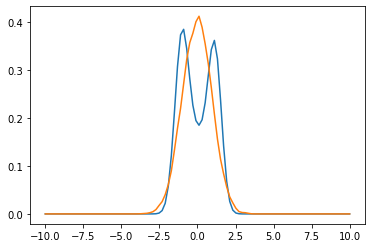

1


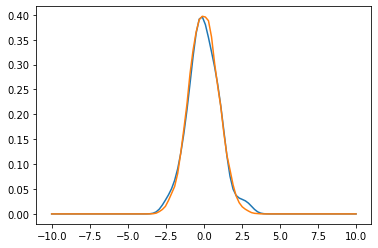

2


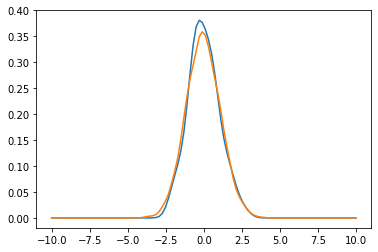

3


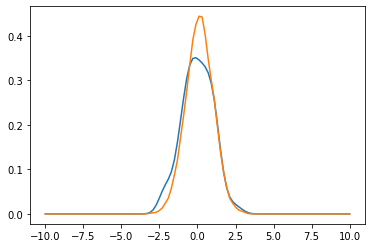

4


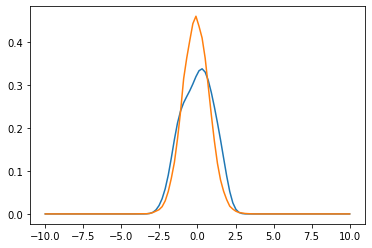

5


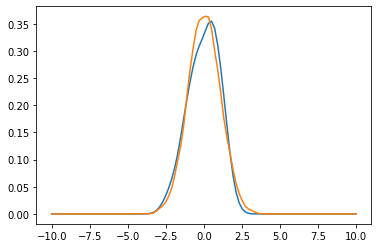

6


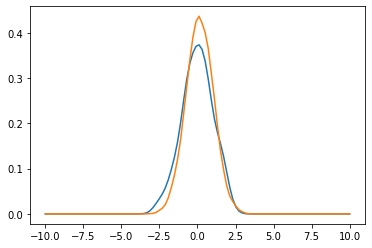

7


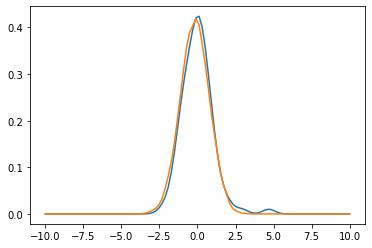

8


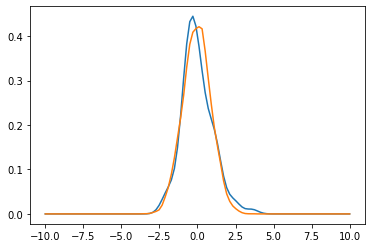

9


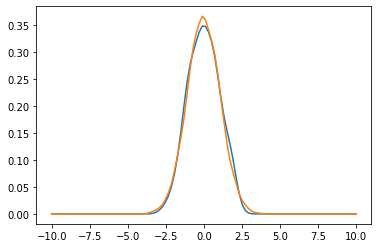

10


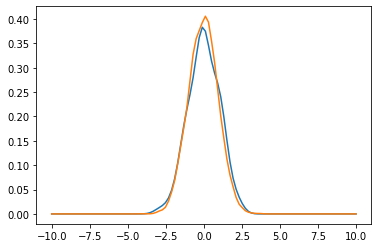

11


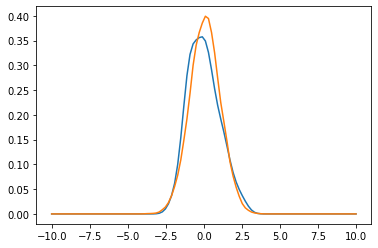

12


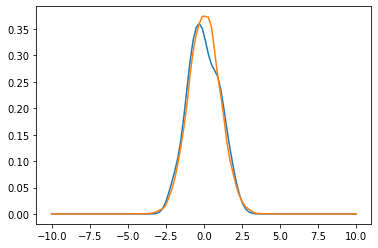

13


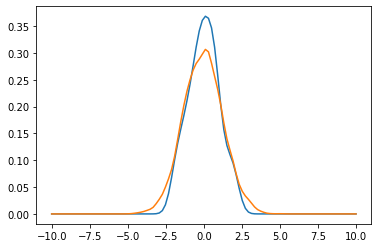

14


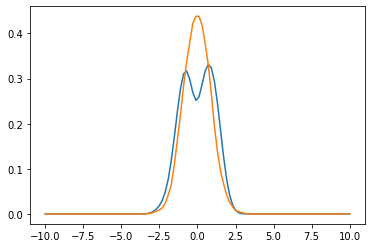

15


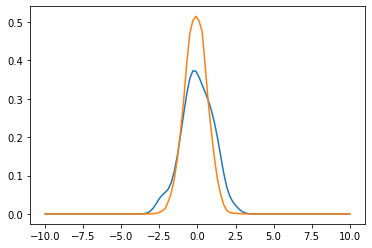

16


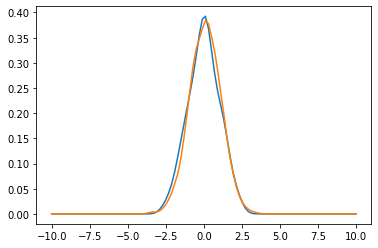

17


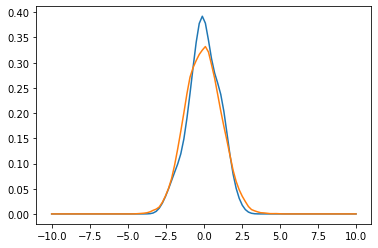

18


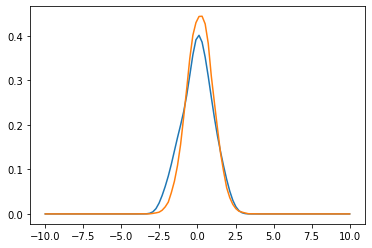

19


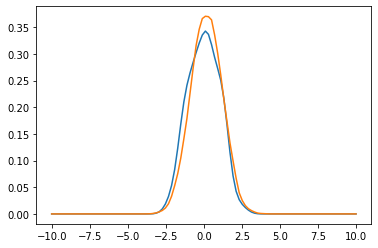

20


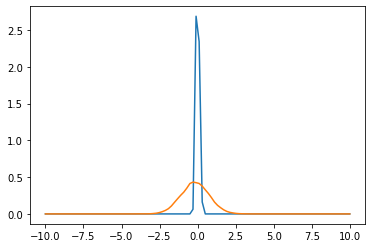

21


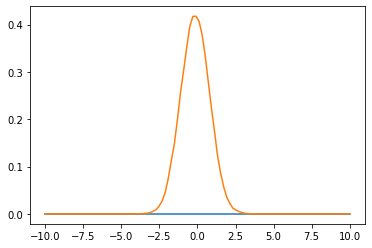

22


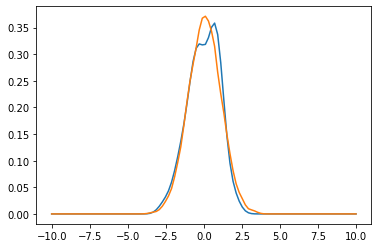

23


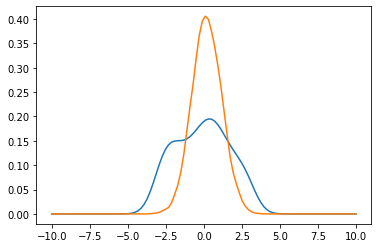

24


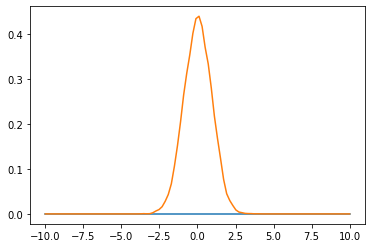

25


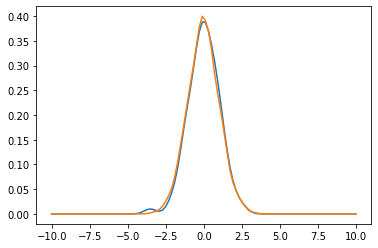

26


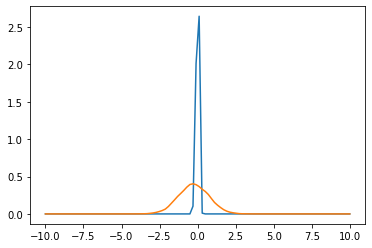

27


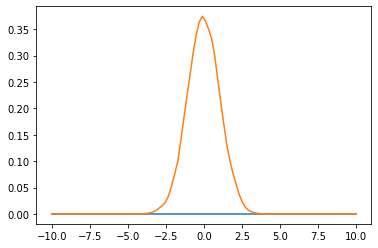

28


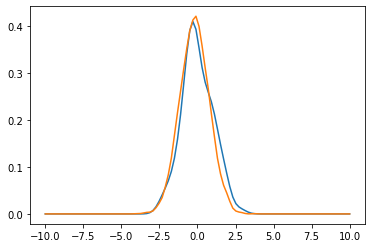

29


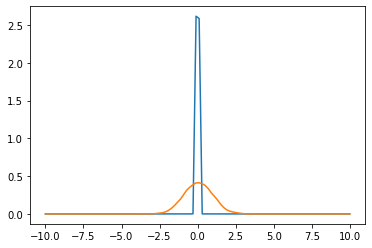

30


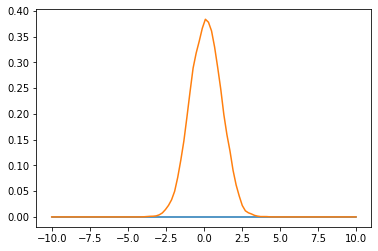

31


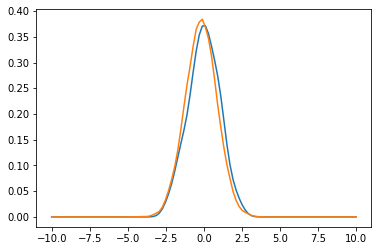

32


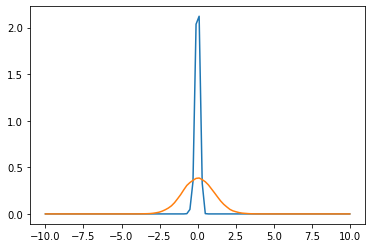

33


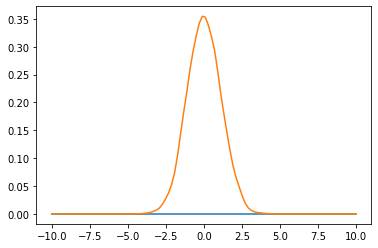

34


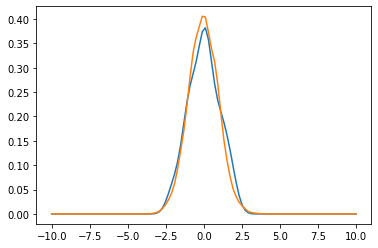

35


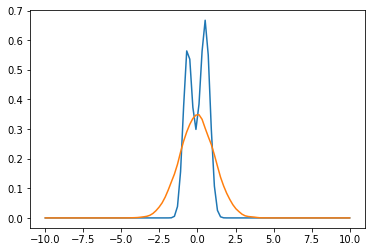

36


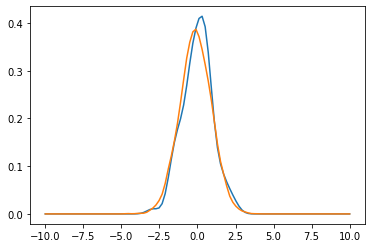

37


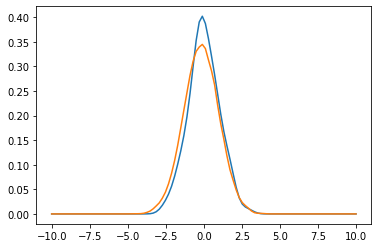

38


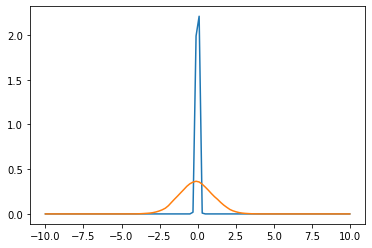

39


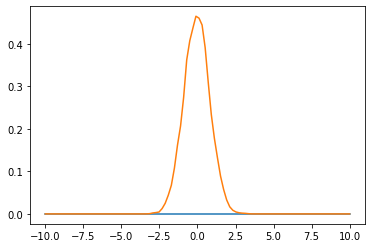

40


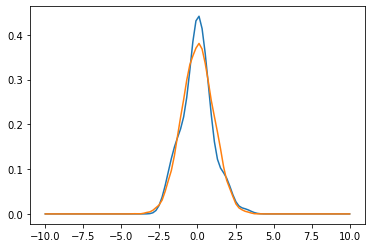

41


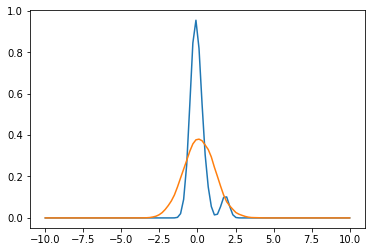

42


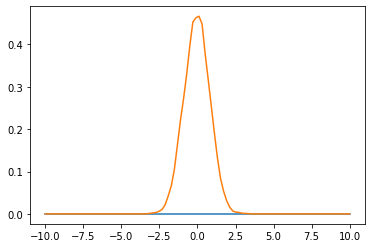

43


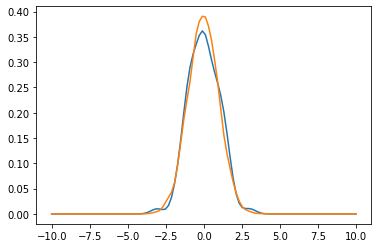

44


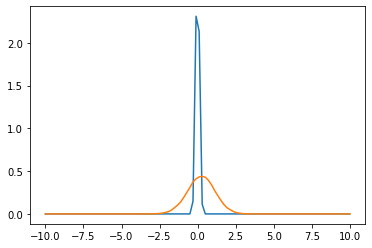

45


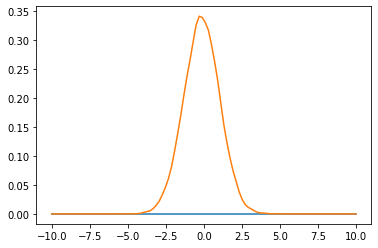

46


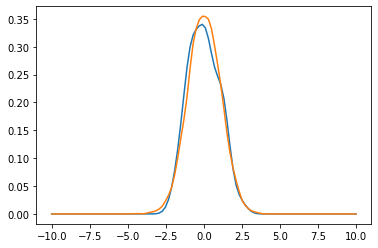

47


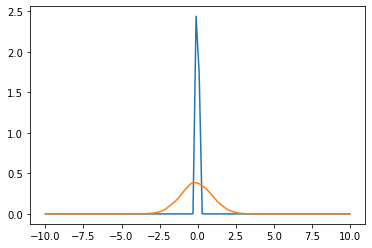

48


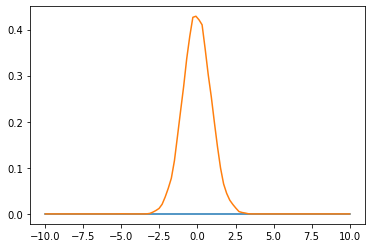

49


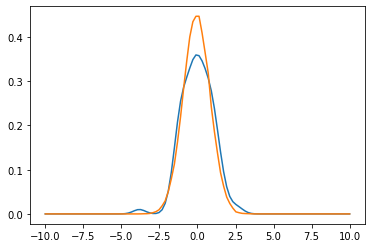

50


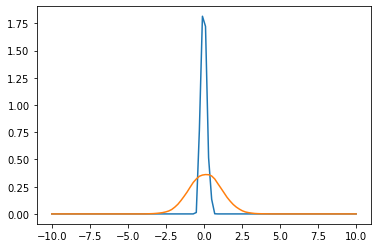

51


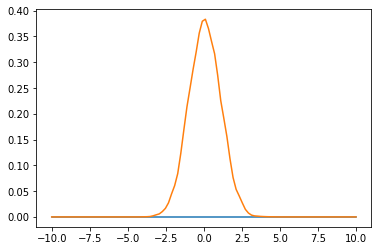

52


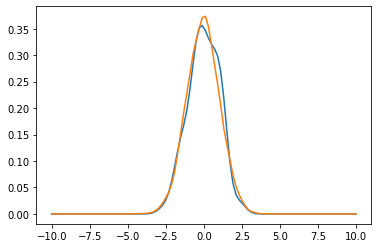

53


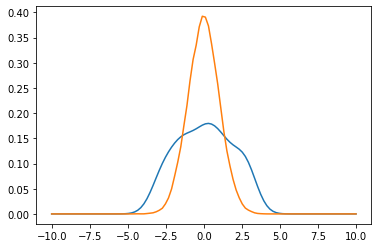

54


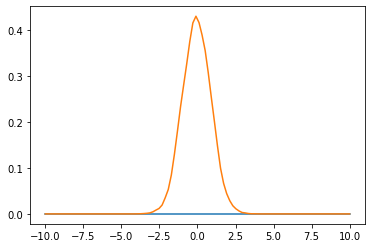

55


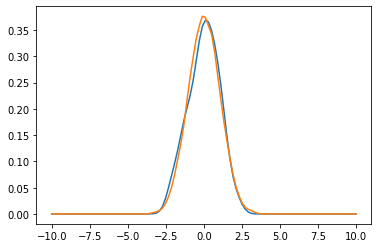

56


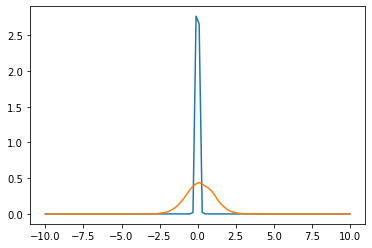

57


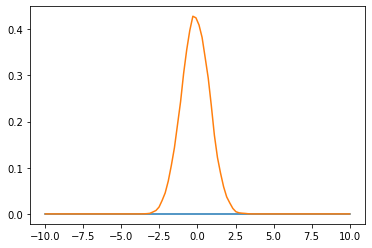

58


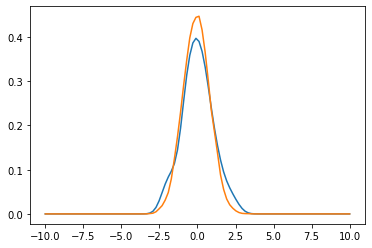

59


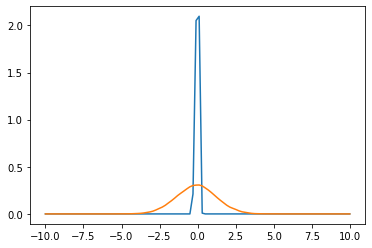

In [12]:
samples,_ = nfm.forward(10000)
samples = samples.cpu().data.numpy()
samples = samples[:, :60]
print(samples.shape)

import scipy.stats

# some training distributions seem flat as they
# are highly concentrated due to the normalisation
# failing when the std is very small

for i in range(60):
    print(i)
    kde_data = scipy.stats.gaussian_kde(x[:, i])
    kde_flow = scipy.stats.gaussian_kde(samples[:, i])
    positions = np.linspace(-10, 10, 100)
    plt.plot(positions, kde_data(positions))
    plt.plot(positions, kde_flow(positions))
    plt.show()